# Colored Noise Robustness of $n$-Local Chain

This notebook investigates the effect of colored noise on entanglement sources in the $n$-local chain.

In [21]:
import pennylane as qml
from pennylane import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import time

from context import qnetvo as QNopt

## Colored Noise

$$
\mathcal{N}(\rho^{AB}) = (1-p)\rho^{AB} + \frac{p}{2} \begin{pmatrix}
    0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 
\end{pmatrix}
$$

In [22]:
from pennylane.operation import Channel

class ColoredNoise(Channel):

    num_params = 1
    num_wires = 2
    par_domain = "R"
    grad_method = "A"
    grad_recipe = ([[1, 0, 1], [-1, 0, 0]],)

    @classmethod
    def _kraus_matrices(cls, *params):
        p = params[0]
            
        kraus_ops = [
            np.eye(4)*np.sqrt(1-p),
            np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) * np.sqrt(p/3),
            np.array([[1,0,0,0],[0,0,-1j,0],[0,1j,0,0],[0,0,0,1]]) * np.sqrt(p/3),
            np.array([[1,0,0,0],[0,1,0,0],[0,0,-1,0],[0,0,0,1]]) * np.sqrt(p/3)
        ]
        
        return kraus_ops
    
# updating default.mixed device to have knowledge of TwoQubitDepolarizing Channel.
dev = qml.device("default.mixed", wires=[0,1]) 
dev.operations.update(["ColoredNoise"])

In [23]:
def trace_distance(A, B):
    return np.sum([np.abs(eig_val) for eig_val in linalg.svd(A - B, hermitian=True)[1]])/2

In [24]:
def RY_CNOT(settings, wires):
    qml.RY(settings[0], wires=wires[0])
    qml.RY(settings[1], wires=wires[1])
    qml.CNOT(wires=wires[0:2])
    
def nlocal_prepare_nodes(n):
    return [QNopt.PrepareNode(1, [2*i, 2*i + 1], RY_CNOT, 2) for i in range(n)]

def local_RY_measure_nodes(n):
    meas_nodes = [QNopt.MeasureNode(2, 2, [0], QNopt.local_RY, 1)]
    meas_nodes.extend([
        QNopt.MeasureNode(2, 2, [2*i + 1, 2*i + 2], QNopt.local_RY, 2) for i in range(0,n-1)
    ])
    meas_nodes.append(QNopt.MeasureNode(2, 2, [2*n-1], QNopt.local_RY, 1))
    
    return meas_nodes

def colored_noise_nodes(n, chan_param):
    return [
        QNopt.NoiseNode([2*i, 2*i + 1], lambda settings, wires: ColoredNoise(chan_param, wires=wires[0:2]))
        for i in range(n)
    ]

In [25]:
params_range = np.append(np.arange(0,1,0.1),[0.99999])
params_range.requires_grad=False

def scan_channel_robustness(n, scan_range):
    
    prep_nodes = nlocal_prepare_nodes(n)
    meas_nodes = local_RY_measure_nodes(n)
    
    opt_violations = np.zeros(11)
    noiseless_violations = np.zeros(11)
    
    depolarized_distances = np.zeros(11)
    noiseless_depolarized_distances = np.zeros(11)
    
    classical_distances = np.zeros(11)
    noiseless_classical_distances = np.zeros(11)
    
    
    ideal_nlocal_ansatz = QNopt.NetworkAnsatz(prep_nodes, meas_nodes)
    noiseless_nlocal_cost = QNopt.nlocal_chain_cost_22(ideal_nlocal_ansatz)        
    for i in range(len(scan_range)):
        chan_param = scan_range[i]

        print("Channel Parameter : ", chan_param)

        noise_nodes = colored_noise_nodes(n, chan_param)

        noisy_nlocal_ansatz = QNopt.NetworkAnsatz(prep_nodes, meas_nodes, noise_nodes)

        @qml.qnode(noisy_nlocal_ansatz.dev)
        def noisy_state(prep_settings):
            noisy_nlocal_ansatz.circuit_layer(noisy_nlocal_ansatz.prepare_nodes)(prep_settings)
            noisy_nlocal_ansatz.circuit_layer(noisy_nlocal_ansatz.noise_nodes)([chan_param]*n)

            return qml.state()

        @qml.qnode(noisy_nlocal_ansatz.dev)
        def noiseless_state(prep_settings):
            ideal_nlocal_ansatz.circuit_layer(ideal_nlocal_ansatz.prepare_nodes)(prep_settings)

            return qml.state()

        noisy_nlocal_cost = QNopt.nlocal_chain_cost_22(noisy_nlocal_ansatz)
        init_settings = noisy_nlocal_ansatz.rand_scenario_settings()

        opt_dict = QNopt.gradient_descent(
            noisy_nlocal_cost,
            init_settings,
            num_steps = 40,
            step_size = 1,
            sample_width = 5,
            verbose=True
        )    

        opt_violations[i] = opt_dict["opt_score"]
        noiseless_violations[i] = -(noiseless_nlocal_cost(opt_dict["opt_settings"]))

        noisy_rho = noisy_state(noisy_nlocal_ansatz.layer_settings(opt_dict["opt_settings"][0], [0]*n))
        ideal_rho = noiseless_state(noisy_nlocal_ansatz.layer_settings(opt_dict["opt_settings"][0], [0]*n))

        depolarized_distances[i] = trace_distance(noisy_rho, np.eye(4**n)/4**n)
        noiseless_depolarized_distances[i] = trace_distance(ideal_rho, np.eye(4**n)/4**n)

        classical_distances[i] = trace_distance(noisy_rho, np.diagflat(np.diag(noisy_rho)))
        noiseless_classical_distances[i] = trace_distance(ideal_rho, np.diagflat(np.diag(ideal_rho)))

    return (
        opt_violations,
        noiseless_violations,
        depolarized_distances,
        noiseless_depolarized_distances,
        classical_distances,
        noiseless_classical_distances,
    )

## Bilocal

In [29]:
%%time

n = 2

(
    bilocal_violations,
    bilocal_noiseless_violations,
    bilocal_depolarized_distances,
    bilocal_noiseless_depolarized_distances,
    bilocal_classical_distances,
    bilocal_noiseless_classical_distances,
) = scan_channel_robustness(n, params_range)

Channel Parameter :  0.0
iteration :  0 , score :  0.25975117022560845
elapsed time :  0.3502352237701416
iteration :  5 , score :  1.274314056692933
elapsed time :  0.355867862701416
iteration :  10 , score :  1.4060149256956243
elapsed time :  0.33918118476867676
iteration :  15 , score :  1.4140815755497331
elapsed time :  0.33283424377441406
iteration :  20 , score :  1.4142118352749145
elapsed time :  0.335817813873291
iteration :  25 , score :  1.4142135402961662
elapsed time :  0.3366847038269043
iteration :  30 , score :  1.4142135620916387
elapsed time :  0.33628082275390625
iteration :  35 , score :  1.4142135623695078
elapsed time :  0.33266401290893555
Channel Parameter :  0.1
iteration :  0 , score :  0.3499660655746226
elapsed time :  0.3370070457458496
iteration :  5 , score :  1.0922581748858848
elapsed time :  0.33792901039123535
iteration :  10 , score :  1.1124972337010357
elapsed time :  0.33577394485473633
iteration :  15 , score :  1.1320765771140928
elapsed time 

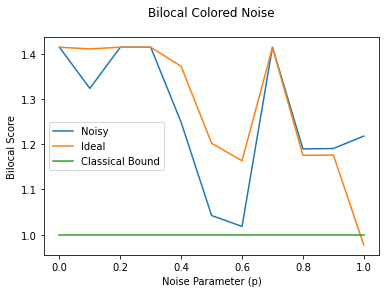

In [34]:
plt.plot(np.arange(0,1.1,0.1), bilocal_violations, label="Noisy")
plt.plot(np.arange(0,1.1,0.1), bilocal_noiseless_violations, label="Ideal")
plt.plot(np.arange(0,1.1,0.1), [1]*11, label="Classical Bound" )
plt.legend()
plt.title("Bilocal Colored Noise\n")
plt.ylabel("Bilocal Score")
plt.xlabel("Noise Parameter (p)")
plt.show()

## Trilocal

In [37]:
%%time

n = 3

(
    trilocal_violations,
    trilocal_noiseless_violations,
    trilocal_depolarized_distances,
    trilocal_noiseless_depolarized_distances,
    trilocal_classical_distances,
    trilocal_noiseless_classical_distances,
) = scan_channel_robustness(n, params_range)

Channel Parameter :  0.0
iteration :  0 , score :  0.1455912153700611
elapsed time :  3.1356422901153564
iteration :  5 , score :  1.0111947106406358
elapsed time :  3.6860618591308594
iteration :  10 , score :  1.1527519097895689
elapsed time :  3.3146307468414307
iteration :  15 , score :  1.3474847991019434
elapsed time :  3.375293016433716
iteration :  20 , score :  1.4116812709094428
elapsed time :  3.1739768981933594
iteration :  25 , score :  1.41412657541537
elapsed time :  3.1738979816436768
iteration :  30 , score :  1.414188686077288
elapsed time :  3.0684640407562256
iteration :  35 , score :  1.4142019085401807
elapsed time :  3.0308890342712402
Channel Parameter :  0.1
iteration :  0 , score :  0.15311534228062823
elapsed time :  3.2681829929351807
iteration :  5 , score :  1.1400985655514484
elapsed time :  3.166494846343994
iteration :  10 , score :  1.2863351062661836
elapsed time :  3.272691011428833
iteration :  15 , score :  1.3597348622443053
elapsed time :  3.4464

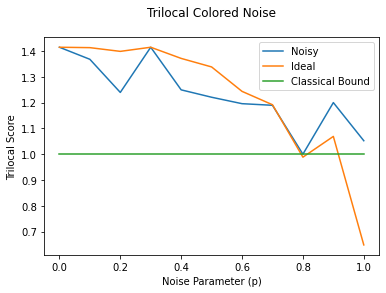

In [38]:
plt.plot(np.arange(0,1.1,0.1), trilocal_violations, label="Noisy")
plt.plot(np.arange(0,1.1,0.1), trilocal_noiseless_violations, label="Ideal")
plt.plot(np.arange(0,1.1,0.1), [1]*11, label="Classical Bound" )
plt.legend()
plt.title("Trilocal Colored Noise\n")
plt.ylabel("Trilocal Score")
plt.xlabel("Noise Parameter (p)")
plt.show()

## Quadlocal

In [42]:
%%time

n = 4

(
    quadlocal_violations,
    quadlocal_noiseless_violations,
    quadlocal_depolarized_distances,
    quadlocal_noiseless_depolarized_distances,
    quadlocal_classical_distances,
    quadlocal_noiseless_classical_distances,
) = scan_channel_robustness(n, params_range)

Channel Parameter :  0.0
iteration :  0 , score :  0.16480017714045542
elapsed time :  62.0219829082489
iteration :  5 , score :  1.134403074200969
elapsed time :  64.40628504753113
iteration :  10 , score :  1.3566656898210117
elapsed time :  65.89897298812866
iteration :  15 , score :  1.4098960200445623
elapsed time :  64.26677894592285
iteration :  20 , score :  1.4131793994219501
elapsed time :  69.46156287193298
iteration :  25 , score :  1.4138098940324175
elapsed time :  64.20634269714355
iteration :  30 , score :  1.4140101783582337
elapsed time :  64.32446002960205
iteration :  35 , score :  1.4140841977327483
elapsed time :  65.38755393028259
Channel Parameter :  0.1
iteration :  0 , score :  0.27843808393014463
elapsed time :  59.41748094558716
iteration :  5 , score :  1.0215540499224487
elapsed time :  58.92574429512024
iteration :  10 , score :  1.1056467296720975
elapsed time :  58.95936417579651
iteration :  15 , score :  1.200739114321252
elapsed time :  59.0179777145

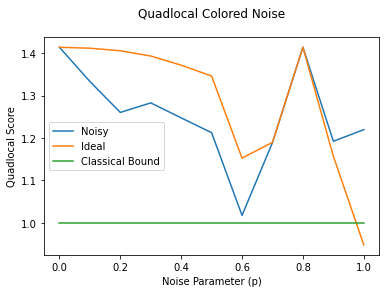

In [43]:
plt.plot(np.arange(0,1.1,0.1), quadlocal_violations, label="Noisy")
plt.plot(np.arange(0,1.1,0.1), quadlocal_noiseless_violations, label="Ideal")
plt.plot(np.arange(0,1.1,0.1), [1]*11, label="Classical Bound" )
plt.legend()
plt.title("Quadlocal Colored Noise\n")
plt.ylabel("Quadlocal Score")
plt.xlabel("Noise Parameter (p)")
plt.show()